# Scientific Python tutorial for the STAR collaboration

This notebook shows you how to do physics analysis in Python using a STAR PicoDST file. I presented it on Zoom on September 13, 2021, but you can find it offline at [jpivarski-talks/2021-09-13-star-uproot-awkward-tutorial](https://github.com/jpivarski-talks/2021-09-13-star-uproot-awkward-tutorial).

You can run this notebook on Binder (see link above), which loads all of the library dependencies onto its server; you don't have to install anything. But if you would like to run it on your computer, see the `requirements.txt` file. This specifies exact versions of dependencies that are known to work for this notebook, though if you plan to use these libraries later on, you'll want the latest versions of each.

The first 5 sections are introductory, and the last contains exercises. In the live tutorial, we spent one hour on the introductory material and one hour in small groups, working on the exercises.

## 1. Python: interactively building up an analysis

## 2. NumPy: thinking one array at a time

## 3. Uproot: array-oriented ROOT I/O

## 4. Awkward Array: complex data in arrays

## 5. Vector, hist, fastjet: the array-oriented ecosystem

## Exercises: translating a C++ analysis into array-oriented Python

In this section, we will plot the mass of e⁺e⁻ pairs from the PicoDST file, using C++ examples as a guide.

The solutions are hidden. Try to solve each exercise on your own (by filling in the "`???`"), then compare with the solutions we've provided.

### C++ version of the analysis

TH1F *hM = new TH1F("hM", "e+e- invariant mass (GeV/c)", 200, 0., 100.);The analysis we want to reproduce is the following:

```c++
// histogram to fill
TH1F *hM = new TH1F("hM", "e+e- invariant mass (GeV/c)", 120, 0, 120);

// get a reader and initialize it
const Char_t *inFile = "pythia_ppZee_run17emb.picoDst.root";
StPicoDstReader* picoReader = new StPicoDstReader(inFile);
picoReader->Init();

Long64_t events2read = picoReader->chain()->GetEntries();

// loop over events
for (Long64_t iEvent = 0; iEvent < events2read; iEvent++) {
  Bool_t readEvent = picoReader->readPicoEvent(iEvent);
  StPicoDst *dst = picoReader->picoDst();

  Int_t nTracks = dst->numberOfTracks();

  // for collecting good tracks
  std::vector<StPicoTrack*> goodTracks;

  // loop over tracks
  for (Int_t iTrk = 0; iTrk < nTracks; iTrk++) {
    StPicoTrack *picoTrack = dst->track(iTrk);

    // track quality cuts
    if (!picoTrack->isPrimary()) continue;
    if (picoTrack->nHitsFit() / picoTrack()->nHitsMax() < 0.2) continue;

    // track -> associated electromagnetic calorimeter energy
    if (picoTrack->isBemcTrack()) {
      StPicoBEmcPidTraits *trait = dst->bemcPidTraits(
          picoTrack->bemcPidTraitsIndex()
      );

      // matched energy cut
      double pOverE = picoTrack->pMom().Mag() / trait->btowE();
      if (pOverE < 0.1) continue;

      // this is a good track
      goodTracks.push_back(picoTrack);
    }
  }

  // loop over good pairs with opposite-sign charge and fill the invariant mass plot
  for (UInt_t i = 0; i < goodTracks.size(); i++) {
    for (UInt_t j = i + 1; j < goodTracks.size(); j++) {
      // make Lorentz vectors with electron mass
      TLorentzVector one(goodTracks[i].pMom(), 0.0005109989461);
      TLorentzVector two(goodTracks[j].pMom(), 0.0005109989461);

      // opposite-sign charge cut
      if (goodTracks[i].charge() != goodTracks[j].charge()) {
        // fill the histogram
        hM->Fill((one + two).M());
      }
    }
  }
}
```

### Reading the data

As before, we start by reading the file.

In [6]:
import uproot
import awkward as ak
import numpy as np

In [7]:
picodst = uproot.open("https://pivarski-princeton.s3.amazonaws.com/pythia_ppZee_run17emb.picoDst.root:PicoDst")
picodst

<TTree 'PicoDst' (18 branches) at 0x7f2b94139850>

By examining the C++ code, we see that we need to compute

```c++
StPicoTrack::isPrimary
StPicoTrack::nHitsFit
StPicoTrack::nHitsMax
StPicoTrack::isBemcTrack
StPicoTrack::bemcPidTraitsIndex
StPicoTrack::pMom
StPicoBEmcPidTraits::btowE
```

From [star-picodst-reference/StPicoTrack.h](star-picodst-reference/StPicoTrack.h) and [star-picodst-reference/StPicoBEmcPidTraits.h](star-picodst-reference/StPicoBEmcPidTraits.h), we learn that these are computed from the following TBranches:

   * `mPMomentumX`
   * `mPMomentumY`
   * `mPMomentumZ`
   * `mNHitsFit`
   * `mNHitsMax`
   * `mBEmcPidTraitsIndex`
   * `mBtowE`

**Exercise 1:** Extract these TBranches as arrays, using the same names.

**Hint:** To avoid long download times while you experiment, set `entry_stop=10` in your calls to [TTree.arrays](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html#arrays) or [TBranch.array](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.TBranch.html#array). Just be sure to remove it to get all entries in the end.

From where I am on the Internet, it took about 30 seconds to read. If it's taking over a minute, you're probably downloading more than you intended.

In [ ]:
mPMomentumX = ???
mPMomentumY = ???
mPMomentumZ = ???
mNHitsFit = ???
mNHitsMax = ???
mBEmcPidTraitsIndex = ???
mBtowE = ???

The types of these arrays should be

In [12]:
(
    mPMomentumX.type,
    mPMomentumY.type,
    mPMomentumZ.type,
    mNHitsFit.type,
    mNHitsMax.type,
    mBEmcPidTraitsIndex.type,
    mBtowE.type,
)

(8004 * var * float32,
 8004 * var * float32,
 8004 * var * float32,
 8004 * var * int8,
 8004 * var * uint8,
 8004 * var * int16,
 8004 * var * float64)

<details style="border: dashed 1px black; padding: 10px">
    <summary><b>Solutions</b> (no peeking!)</summary>

<br>

There are several ways to get these data; here are two.

**(1)** You could navigate to each TBranch and ask for its `array`.

```python
mPMomentumX = picodst["Track.mPMomentumX"].array()
mPMomentumY = picodst["Track.mPMomentumY"].array()
mPMomentumZ = picodst["Track.mPMomentumZ"].array()
mNHitsFit = picodst["Track.mNHitsFit"].array()
mNHitsMax = picodst["Track.mNHitsMax"].array()
mBEmcPidTraitsIndex = picodst["Track.mBEmcPidTraitsIndex"].array()
mBtowE = picodst["EmcPidTraits.mBtowE"].array() / 1000
```
<br>

**(2)** You could ask the TTree for its `arrays`, with a filter to keep from reading everything over the network, then extract each field of the resulting record array. (There's a slight performance advantage to this method, since it only has to make 1 request across the network, rather than 7, _if_ you filter the TBranches to read. If you don't, _it will read all branches_, which will take much longer.)

```python
single_array = picodst.arrays(filter_name=[
    "Track.mPMomentum[XYZ]",
    "Track.mNHits*",
    "Track.mBEmcPidTraitsIndex",
    "EmcPidTraits.mBtowE",
])
mPMomentumX = single_array["Track.mPMomentumX"]
mPMomentumY = single_array["Track.mPMomentumY"]
mPMomentumZ = single_array["Track.mPMomentumZ"]
mNHitsFit = single_array["Track.mNHitsFit"]
mNHitsMax = single_array["Track.mNHitsMax"]
mBEmcPidTraitsIndex = single_array["Track.mBEmcPidTraitsIndex"]
mBtowE = single_array["EmcPidTraits.mBtowE"] / 1000
```
<br>


Either way, be sure to divide the `mBtowE` branch by 1000, as it is in the C++ code.
</details>

### Making momentum objects with charges

The C++ code uses ROOT [TVector3](https://root.cern.ch/doc/master/classTVector3.html) and [TLorentzVector](https://root.cern.ch/doc/master/classTLorentzVector.html) objects for vector calculations. We'll use the (array-oriented) Vector library.

The definitions of `pMom` and `charge` are

```c++
  TVector3 pMom() const            { return TVector3(mPMomentumX, mPMomentumY, mPMomentumZ); }
  Short_t charge() const           { return (mNHitsFit > 0) ? 1 : -1; }
```
mPMomentumX, mPMomentumY, mPMomentumZ
(Yes, the `charge` bit is hidden inside the `mNHitsFit` integer.)

In [48]:
import vector
vector.register_awkward()

In [50]:
import particle, hepunits
electron_mass = particle.Particle.find("e-").mass / hepunits.GeV
electron_mass

0.0005109989460999999

**Exercise 2a:** First, make an array of `charge` as positive and negative `1` integers. You may use [ak.where](https://awkward-array.readthedocs.io/en/latest/_auto/ak.where.html) or clever arithmetic.

In [ ]:
charge = ???

The type should be:

In [53]:
charge.type

8004 * var * int64

And the first and last values should be:

In [54]:
charge

<Array [[1, 1, 1, 1, 1, ... 1, 1, -1, -1, 1]] type='8004 * var * int64'>

**Exercise 2b:** Next, use [ak.zip](https://awkward-array.readthedocs.io/en/latest/_auto/ak.zip.html) to combine `mPMomentumX`, `mPMomentumY`, `mPMomentumZ`, `electron_mass`, and `charge` into a single array of type

```python
8004 * var * {"px": float32, "py": float32, "pz": float32, "M": float64, "charge": int64}
```

It is very important that the type is lists of records (`var * {"px": float32, ...}`), not records of lists (`{"px": var * float32, ...}`).

In [ ]:
record_array = ???

The second record in the first event should be:

In [63]:
record_array[0, 1].tolist()

{'px': -0.14229480922222137,
 'py': 0.3735402524471283,
 'pz': 0.15136101841926575,
 'M': 0.0005109989460999999,
 'charge': 1}

**Exercise 2c:** Finally, search Awkward Array's [reference documentation](https://awkward-array.readthedocs.io/) for a way to add the `"Momentum4D"` name to these records to turn them into Lorentz vectors.

In [ ]:
pMom = ???

The type of `pMom` should be:

In [65]:
pMom.type

8004 * var * Momentum4D["px": float32, "py": float32, "pz": float32, "M": float64, "charge": int64]

Lorentz vector operations don't require the `"charge"`, but it will be convenient to keep that in the same package. The Vector library will ignore it.

<details style="border: dashed 1px black; padding: 10px">
    <summary><b>Solutions</b> (no peeking!)</summary>

<br>

The charge can be computed using:

```python
charge = ak.where(mNHitsFit > 0, 1, -1)
```
<br>

or "clever arithmetic" (booleans in a numerical expression become `false → 0`, `true → 1`):

```python
charge = (mNHitsFit > 0) * 2 - 1
```
<br>

Making the record array is a direct application of [ak.zip](https://awkward-array.readthedocs.io/en/latest/_auto/ak.zip.html):

```python
record_array = ak.zip(
    {"px": mPMomentumX, "py": mPMomentumY, "pz": mPMomentumZ, "M": electron_mass, "charge": charge}
)
```
<br>

Combining the variable-length lists of `mPMomentumX`, `mPMomentumY`, `mPMomentumZ`, and `charge` is just what [ak.zip](https://awkward-array.readthedocs.io/en/latest/_auto/ak.zip.html) does (and if those lists had different lengths, it would raise an error). Only using `depth_limit=1` or the [ak.Array](https://awkward-array.readthedocs.io/en/latest/_auto/ak.Array.html) constructor would produce the wrong type.

Also, the constant `electron_mass` does not need special handling. Constants and lower-dimension arrays are [broadcasted](https://awkward-array.readthedocs.io/en/latest/_auto/ak.broadcast_arrays.html) to the same shape as larger-dimension arrays when used in the same function. (This is similar to, but an extension of, NumPy's [concept of broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html).)

Finally, to add the `"Momentum4D"` name to all the records, you could use [ak.zip](https://awkward-array.readthedocs.io/en/latest/_auto/ak.zip.html) again, as it has a `with_name` argument:

```python
pMom = ak.zip(
    {"px": mPMomentumX, "py": mPMomentumY, "pz": mPMomentumZ, "M": electron_mass, "charge": charge},
    with_name="Momentum4D",
)
```
<br>

Or pass the already-built `record_array` into [ak.with_name](https://awkward-array.readthedocs.io/en/latest/_auto/ak.with_name.html):

```python
pMom = ak.with_name(record_array, "Momentum4D")
```
<br>

Or pass the already-built `record_array` into the [ak.Array](https://awkward-array.readthedocs.io/en/latest/_auto/ak.Array.html) constructor with a `with_name` argument:

```python
pMom = ak.Array(record_array, with_name="Momentum4D")
```
</details>

### Computing track cuts

In the C++, the following cuts are applied to the tracks:

```c++
if (!picoTrack->isPrimary()) continue;
if (picoTrack->nHitsFit() / picoTrack()->nHitsMax() < 0.2) continue;
if (picoTrack->isBemcTrack()) {
  // ...
}
```

Some of the cuts in C++ are applied by jumping to the next loop iteration with `continue` (a dangerous practice, in my opinion) while another is in a nested `if` statement. Note that the `continue` conditions describe the _opposite_ of a good track.

The quantities used in the cuts are defined in [star-picodst-reference/StPicoTrack.h](star-picodst-reference/StPicoTrack.h):

```c++
  Bool_t isPrimary() const         { return ( pMom().Mag()>0 ); }
  TVector3 pMom() const            { return TVector3(mPMomentumX, mPMomentumY, mPMomentumZ); }

  Int_t   nHitsFit() const         { return (mNHitsFit > 0) ? (Int_t)mNHitsFit : (Int_t)(-1 * mNHitsFit); }
  Int_t   nHitsMax() const         { return (Int_t)mNHitsMax; }

  Bool_t isBemcTrack() const       { return (mBEmcPidTraitsIndex<0) ? false : true; }
```

**Exercise 3:** Convert these cuts into a [boolean array slice](https://awkward-array.readthedocs.io/en/latest/_auto/ak.Array.html#filtering).

In [ ]:
isPrimary = ???
nHitsFit = ???
nHitsMax = ???
isBemcTrack = ???

track_quality_cuts = ???

The type of `track_quality_cuts` should be:

In [15]:
track_quality_cuts.type

8004 * var * bool

And the number of passing tracks in the first and last events should be:

In [16]:
np.count_nonzero(track_quality_cuts, axis=1)

<Array [3, 2, 2, 1, 2, 1, ... 1, 1, 2, 1, 4, 4] type='8004 * int64'>

<details style="border: dashed 1px black; padding: 10px">
    <summary><b>Solutions</b> (no peeking!)</summary>

<br>

There are several equivalent ways to compute `isPrimary`:

```python
isPrimary = (abs(mPMomentumX) > 0) & (abs(mPMomentumY) > 0) & (abs(mPMomentumZ) > 0)
```
<br>

and

```python
isPrimary = mPMomentumX**2 + mPMomentumY**2 + mPMomentumZ**2 > 0   # or with np.sqrt
```
<br>

The most straightforward way to compute `nHitsFit` is:

```python
nHitsFit = abs(mNHitsFit)
```
<br>

but you could use [ak.where](https://awkward-array.readthedocs.io/en/latest/_auto/ak.where.html)/[np.where](https://numpy.org/doc/stable/reference/generated/numpy.where.html) to make it look more like the C++:

```python
nHitsFit = np.where(mNHitsFit > 0, mNHitsFit, -1 * mNHitsFit)
```
<br>

`nHitsMax` is exactly equal to `mNHitsMax`, and `isBemcTrack` is:

```python
isBemcTrack = mBEmcPidTraitsIndex >= 0   # be sure to get the inequality right
```
<br>

or

```python
isBemcTrack = np.where(mBEmcPidTraitsIndex < 0, False, True)
```
<br>

to make it look more like the C++.

Finally, `track_quality_cuts` is a logical-AND of three selections:

```python
track_quality_cuts = isPrimary & (nHitsFit / nHitsMax >= 0.2) & isBemcTrack
```
<br>

Be sure to get the inequality right: `continue` _throws away_ bad tracks, but we want an expression that will _keep_ good tracks.
</details>

### Matching tracks to electromagnetic showers

The final track quality cut requires us to match the track with its corresponding shower. Tracks and showers have different multiplicities.

In [31]:
ak.num(mPMomentumX), ak.num(mBtowE)

(<Array [2594, 2513, 2909, ... 2441, 2586, 2321] type='8004 * int64'>,
 <Array [7, 4, 4, 2, 4, 1, ... 2, 2, 7, 1, 8, 8] type='8004 * int64'>)

The PicoDst file provides us with an index for each track that is the position of the corresponding shower in the showers array. It is `-1` when there is no corresponding shower.

In [32]:
mBEmcPidTraitsIndex

<Array [[-1, -1, -1, -1, ... -1, -1, -1, -1]] type='8004 * var * int16'>

**Exercise 4:** Filter `mBEmcPidTraitsIndex` with `track_quality_cuts` and make an array of shower energy `mBtowE` for each quality track.

In [ ]:
quality_mBtowE = ???

The type of `quality_mBtowE` should be:

In [34]:
quality_mBtowE.type

8004 * var * float64

Its first and last values should be:

In [35]:
quality_mBtowE

<Array [[1.71, 32.8, 0], ... 0, 17.8, 0.36]] type='8004 * var * float64'>

And it should have as many values in each event as there are "`true`" booleans in `track_quality_cuts`:

In [46]:
ak.num(quality_mBtowE)

<Array [3, 2, 2, 1, 2, 1, ... 1, 1, 2, 1, 4, 4] type='8004 * int64'>

In [47]:
np.all(ak.num(quality_mBtowE) == np.count_nonzero(track_quality_cuts, axis=1))

True

<details style="border: dashed 1px black; padding: 10px">
    <summary><b>Solutions</b> (no peeking!)</summary>

<br>

The answer could be written in one line:

```python
quality_mBtowE = mBtowE[mBEmcPidTraitsIndex[track_quality_cuts]]
```
<br>

The first part, `mBEmcPidTraitsIndex[track_quality_cuts]`, applies the track quality cuts to the `mBEmcPidTraitsIndex` so that there are no more `-1` values in it. The remaining array of lists of integers is exactly what is required to pick energy values from `mBtowE` in lists of the right lengths and orders.

Naturally, you could write it in two lines (or as many as you find easy to read).

If you know about [ak.mask](https://awkward-array.readthedocs.io/en/latest/_auto/ak.mask.html), you might have tried masking `mBEmcPidTraitsIndex` instead of filtering it:

```python
quality_mBEmcPidTraitsIndex = mBEmcPidTraitsIndex.mask[track_quality_cuts]
quality_mBtowE = mBtowE[quality_mBEmcPidTraitsIndex]
```
<br>

Instead of changing the lengths of the lists by dropping bad tracks, this would replace them with missing value placeholders ("`None`"). _This is not wrong,_ and it's a good alternative to the overall problem because it simplifies the process of filtering filtered data. (The placeholders keep the arrays the same lengths, so cuts can be applied in any order.)

However, it changes how the next step would have to be handled, and you'd eventually have to use [ak.is_none](https://awkward-array.readthedocs.io/en/latest/_auto/ak.is_none.html) to remove the missing values. For the sake of this walkthrough, to keep everyone on the same page, let's not do that.
</details>

### Applying the energy cut and making track-pairs

The last quality cut requires total track momentum divided by shower energy to be at least 0.1.

We can get the total track momentum from `pMom.mag` (3D magnitude of 3D or 4D vectors), but apply the quality cuts to it so that it has the same length as `quality_mBtowE` (which already has quality cuts applied).

In [80]:
pMom.mag

<Array [[0, 0.427, 0, 0, 0, ... 0, 0, 0, 0, 0]] type='8004 * var * float32'>

In [79]:
quality_total_momentum = pMom[track_quality_cuts].mag
quality_total_momentum

<Array [[1.07, 24.4, 2.81, ... 18.6, 1.88]] type='8004 * var * float32'>

In [84]:
quality_pOverE = quality_total_momentum / quality_mBtowE
quality_pOverE

<Array [[0.626, 0.745, inf, ... 1.04, 5.23]] type='8004 * var * float64'>

(You may see a warning when calculating the above; some values of the denominator are zero. It's possible to selectively suppress such messages with NumPy's [np.errstate](https://numpy.org/doc/stable/reference/generated/numpy.errstate.html).)

In [85]:
quality_pOverE_cut = (quality_pOverE >= 0.1)

In [86]:
np.count_nonzero(quality_pOverE_cut, axis=1)

<Array [3, 2, 2, 1, 2, 1, ... 1, 1, 2, 1, 3, 4] type='8004 * int64'>

An array with all cuts applied, the equivalent of `goodTracks` in the C++, is:

In [87]:
goodTracks = pMom[track_quality_cuts][quality_pOverE_cut]
goodTracks

<MomentumArray4D [[{px: 0.000914, ... charge: -1}]] type='8004 * var * Momentum4...'>

(As mentioned in one of the solutions, above, [ak.mask](https://awkward-array.readthedocs.io/en/latest/_auto/ak.mask.html) would allow `track_quality_cuts` and `quality_pOverE_cut` to be applied in either order, at the expense of having to remove the placeholder "`None`" values with [ak.is_none](https://awkward-array.readthedocs.io/en/latest/_auto/ak.is_none.html). Extra credit if you can rework all of the above to use this technique.)

**Exercise 5a:** Use [ak.combinations](https://awkward-array.readthedocs.io/en/latest/_auto/ak.combinations.html) to make all pairs of good tracks, per event, the equivalent of this code:

```c++
for (UInt_t i = 0; i < goodTracks.size(); i++) {
  for (UInt_t j = i + 1; j < goodTracks.size(); j++) {
    // make Lorentz vectors with electron mass
    TLorentzVector one(goodTracks[i].pMom(), 0.0005109989461);
    TLorentzVector two(goodTracks[j].pMom(), 0.0005109989461);
```

In [ ]:
pairs = ???

The type of `pairs` should be lists of 2-tuples of Momentum4D:

In [92]:
pairs.type

8004 * var * (Momentum4D["px": float32, "py": float32, "pz": float32, "M": float64, "charge": int64], Momentum4D["px": float32, "py": float32, "pz": float32, "M": float64, "charge": int64])

And the number of such pairs in the first and last events should be:

In [93]:
ak.num(pairs)

<Array [3, 1, 1, 0, 1, 0, ... 0, 0, 1, 0, 3, 6] type='8004 * int64'>

Note that this is not the same as the number of good tracks:

In [97]:
ak.num(goodTracks)

<Array [3, 2, 2, 1, 2, 1, ... 1, 1, 2, 1, 3, 4] type='8004 * int64'>

In particular, 3 good tracks → 3 pairs, 2 good tracks → 1 pair, and 4 good tracks → 6 pairs ($n$ choose $2$ = $n(n - 1)/2$ for $n$ good tracks).

**Exercise 5b:** Search Awkward Array's [reference documentation](https://awkward-array.readthedocs.io/) for a way to get an array named `one` with the first of each pair and an array named `two` with the second of each pair, as two arrays with equal-length lists.

In [ ]:
one, two = ???

The types of `one` and `two` should be:

In [102]:
one.type, two.type

(8004 * var * Momentum4D["px": float32, "py": float32, "pz": float32, "M": float64, "charge": int64],
 8004 * var * Momentum4D["px": float32, "py": float32, "pz": float32, "M": float64, "charge": int64])

And the lengths of their lists should be the same as `ak.num(goodTracks)` (above).

In [103]:
ak.num(one), ak.num(two)

(<Array [3, 1, 1, 0, 1, 0, ... 0, 0, 1, 0, 3, 6] type='8004 * int64'>,
 <Array [3, 1, 1, 0, 1, 0, ... 0, 0, 1, 0, 3, 6] type='8004 * int64'>)

**Hint:** Remember how we _combined_ arrays of lists of the same lengths into `record_array`? This is the opposite of that.

<details style="border: dashed 1px black; padding: 10px">
    <summary><b>Solutions</b> (no peeking!)</summary>

<br>

The first step is a direct application of the [ak.combinations](https://awkward-array.readthedocs.io/en/latest/_auto/ak.combinations.html) function:

```python
pairs = ak.combinations(goodTracks, 2)
```
<br>

The default `axis` is `axis=1`, which means to find all combinations in each entry. (Not all combinations of entries, which would be `axis=0`!)

The second step could be a direct application of [ak.unzip](https://awkward-array.readthedocs.io/en/latest/_auto/ak.unzip.html):

```python
one, two = ak.unzip(pairs)
```
<br>

But tuples, like the 2-tuples in these `pairs`, are just records with unnamed fields. We can extract record fields with string-valued slices, and tuples can be indexed by position, so the slices that would extract the first of all tuple fields and the second of all tuple fields is `"0"` (a string!) and `"1"` (a string!).

```python
one, two = pairs["0"], pairs["1"]
```
<br>

That's prone to misunderstanding: the numbers really must be inside strings. Perhaps a safer way to do it is:

```python
one, two = pairs.slot0, pairs.slot1
```
<br>

which works up to `slot9`. Whereas these methods extract one tuple-field at a time, [ak.unzip](https://awkward-array.readthedocs.io/en/latest/_auto/ak.unzip.html) extracts all fields (of any tuple _or_ record).
</details>

### Selecting opposite-sign charges among those pairs

The opposite-sign charge cut is not a track quality cut, since it depends on a relationship between two tracks.

Now we have arrays `one` and `two` representing the left and right halves of those pairs, and we can define and apply the cut.

**Exercise 6a:** Make an array of booleans that are `true` for opposite-sign charges and `false` for same-sign charges.

In [ ]:
opposite_charge_cut = ???

The type should be:

In [105]:
opposite_charge_cut.type

8004 * var * bool

And the number of `true` values in the first and last events should be:

In [115]:
ak.count_nonzero(opposite_charge_cut, axis=1)

<Array [2, 1, 0, 0, 1, 0, ... 0, 0, 1, 0, 2, 3] type='8004 * int64'>

**Exercise 6b:** Apply that cut to `one` and `two`.

In [ ]:
quality_one = ???
quality_two = ???

The types should be remain:

In [110]:
quality_one.type, quality_two.type

(8004 * var * Momentum4D["px": float32, "py": float32, "pz": float32, "M": float64, "charge": int64],
 8004 * var * Momentum4D["px": float32, "py": float32, "pz": float32, "M": float64, "charge": int64])

And the lengths of the lists should become:

In [111]:
ak.num(quality_one), ak.num(quality_two)

(<Array [2, 1, 0, 0, 1, 0, ... 0, 0, 1, 0, 2, 3] type='8004 * int64'>,
 <Array [2, 1, 0, 0, 1, 0, ... 0, 0, 1, 0, 2, 3] type='8004 * int64'>)

<details style="border: dashed 1px black; padding: 10px">
    <summary><b>Solutions</b> (no peeking!)</summary>

<br>

I've seen three different ways people calculate opposite-sign charges. I think this is the simplest:

```python
opposite_charge_cut = one.charge != two.charge
```
<br>

This one is also intuitive, since the Z boson that decays to two electrons has net zero charge:

```python
opposite_charge_cut = one.charge + two.charge == 0
```
<br>

This one is odd, but I see it quite a lot:

```python
opposite_charge_cut = one.charge * two.charge == -1
```
<br>

As for applying the cut, the pattern should be getting familiar:


```python
quality_one = one[opposite_charge_cut]
quality_two = two[opposite_charge_cut]
```
</details>

### Computing invariant mass of the track pairs

Up to this point, the only Lorentz vector method that we used was `mag`. Now we want to add the left and right halves of each pair and compute their invariant mass.

**Exercise 7:** Check the [Vector documentation](https://vector.readthedocs.io/en/latest/usage/intro.html) and figure out how to do that.

In [ ]:
invariant_mass = ???

The type should be:

In [127]:
invariant_mass.type

8004 * var * float64

The first and last values should be:

In [128]:
invariant_mass

<Array [[6.51, 16.2], ... [2.49, 8.24, 3.5]] type='8004 * var * float64'>

And the lengths of each list in the first and last events should be:

In [129]:
ak.num(invariant_mass)

<Array [2, 1, 0, 0, 1, 0, ... 0, 0, 1, 0, 2, 3] type='8004 * int64'>

<details style="border: dashed 1px black; padding: 10px">
    <summary><b>Solutions</b> (no peeking!)</summary>

<br>

It could look (almost) exactly like the C++:

```python
invariant_mass = (quality_one + quality_two).M
```
<br>

But I prefer:

```python
invariant_mass = (quality_one + quality_two).mass
```
<br>

The Vector library has only one way to "spell" this quantity for purely geometric vectors, "`tau`" (for proper time), but when vectors are labeled as "Momentum", they get synonyms: "`mass`", "`M`", "`m`".

It's worth noting that `(quality_one + quality_two)` is a new array of vectors, and therefore the fields Vector doesn't recognize are lost. The type of `(quality_one + quality_two)` is:

```
8004 * var * Momentum4D["x": float32, "y": float32, "z": float32, "tau": float64]
```
<br>

with no `"charge"`. Vector does not add the charges because adding would not be the correct thing to do with any unrecognized field. (You might have named it `"q"` or `"Q"`.) Of course, you can add it yourself:


```python
quality_one.charge + quality_two.charge
```
<br>

and insert it into a new object. This works, for instance:

```python
z_bosons = (quality_one + quality_two)
z_bosons["charge"] = quality_one.charge + quality_two.charge
```
<br>

and `z_bosons` has type

```
8004 * var * Momentum4D["x": float32, "y": float32, "z": float32, "tau": float64, "charge": int64]
```
</details>

### Plotting the invariant mass

Constructing a histogram, which was the first step in C++:

```c++
TH1F *hM = new TH1F("hM", "e+e- invariant mass (GeV/c)", 120, 0, 120);
```

is the last step here.

In [136]:
import hist

**Exercise 8:** Check the [hist documentation](https://hist.readthedocs.io/en/latest/user-guide/quickstart.html) and define a one-dimensional histogram with 120 regularly-spaced bins from 0 to 120 GeV. Then fill it with the `invariant_mass` data.

**Hint:** The `invariant_mass` array contains _lists_ of numbers, but histograms present a distribution of _numbers_. Search Awkward Array's [reference documentation](https://awkward-array.readthedocs.io/) for a way to flatten these lists into a one-dimensional array, and experiment with that step _before_ attempting to fill the histogram. (The error messages will be easier to understand.)

In [ ]:
flat_invariant_mass = ???
hM = ???
hM.fill(???)

The flattened invariant mass should look like this:

In [149]:
flat_invariant_mass

<Array [6.51, 16.2, 108, ... 2.49, 8.24, 3.5] type='5021 * float64'>

Note that the type does not have any "`var`" in it.

Whenever a `hist.Hist` is the return value of an expression in Jupyter (such as after the `fill`), you'll see a mini-plot to aid in interactive analysis. But professional-quality plots are made through Matplotlib:

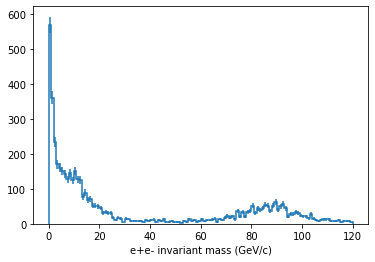

In [143]:
hM.plot();

By importing Matplotlib, we can configure the plot, mix it with other plots, tweak how it looks, etc.

In [144]:
import matplotlib.pyplot as plt

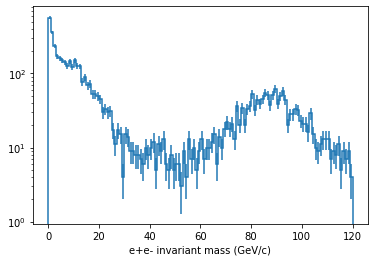

In [145]:
hM.plot()
plt.yscale("log")

**Physics note:** The broad peak at 85 GeV _is_ the Z boson (in this Monte Carlo sample). It's offset from the 91 GeV Z mass and has a width of 14 GeV due to tracking resolution for these high-momentum tracks (roughly 40 GeV per track).

<details style="border: dashed 1px black; padding: 10px">
    <summary><b>Solutions</b> (no peeking!)</summary>

<br>

The `invariant_mass` array can be flattened with [ak.flatten](https://awkward-array.readthedocs.io/en/latest/_auto/ak.flatten.html) or [ak.ravel](https://awkward-array.readthedocs.io/en/latest/_auto/ak.ravel.html)/[np.ravel](https://numpy.org/doc/stable/reference/generated/numpy.ravel.html). The [ak.flatten](https://awkward-array.readthedocs.io/en/latest/_auto/ak.flatten.html) function only flattens one dimension (by default, `axis=1`), which is all we need in this case. "Ravel" is NumPy's spelling for "flatten all dimensions."

```python
flat_invariant_mass = ak.flatten(invariant_mass)
```
<br>

or

```python
flat_invariant_mass = np.ravel(invariant_mass)
```
<br>

The reason you have to do this manually is because it's an information-losing operation: [there are many ways](https://awkward-array.org/how-to-restructure-flatten.html) to get a dimensionless set of values from nested data, and in some circumstances, you might have wanted one of the other ones. For instance, maybe you want to ensure that you only plot one Z candidate per event, and you have some criteria for selecting the "best" one. This is where you would put that alternative.

As for constructing the histogram and filling it:

```python
hM = hist.Hist(hist.axis.Regular(120, 0, 120, label="e+e- invariant mass (GeV/c)"))
hM.fill(flat_invariant_mass)
```
<br>

Be sure to use hist's array-oriented `fill` method. Iterating over the values in the array (or even the lists withing an array of lists) would be hundreds of times slower than filling it in one call.

Calling `fill` multiple times to accumulate batches, however, is fine: the important thing is to give it a large array with each call, so that most of its time can be spent in its compiled histogram-fill loop, not in Python loops.</details>

In [147]:
flat_invariant_mass.type

5021 * float64

In [148]:
flat_invariant_mass

<Array [6.51, 16.2, 108, ... 2.49, 8.24, 3.5] type='5021 * float64'>

In [151]:
flat_invariant_mass = np.ravel(invariant_mass)

hM = hist.Hist(hist.axis.Regular(120, 0, 120, label="e+e- invariant mass (GeV/c)"))
hM.fill(flat_invariant_mass)

Hist(Regular(120, 0, 120, label='e+e- invariant mass (GeV/c)'), storage=Double()) # Sum: 4962.0 (5021.0 with flow)

```c++
  Bool_t isPrimary() const         { return ( pMom().Mag()>0 ); }
  Int_t   nHitsFit() const         { return (mNHitsFit > 0) ? (Int_t)mNHitsFit : (Int_t)(-1 * mNHitsFit); }
  Int_t   nHitsMax() const         { return (Int_t)mNHitsMax; }
  Bool_t isBemcTrack() const       { return (mBEmcPidTraitsIndex<0) ? false : true; }
  Int_t bemcPidTraitsIndex() const { return mBEmcPidTraitsIndex; }
  TVector3 pMom() const            { return TVector3(mPMomentumX, mPMomentumY, mPMomentumZ); }
  Float_t btowE() const            { return (Float_t)mBtowE / 1000.; }
  Short_t charge() const           { return (mNHitsFit > 0) ? 1 : -1; }
```

In [star-picodst-W-reference-for-jim/macros/PicoDstAnalyzer.C](star-picodst-W-reference-for-jim/macros/PicoDstAnalyzer.C), the chain of commands that leads to getting a track is:

```c++
// get a reader and initialize it
const Char_t *inFile = "pythia_ppZee_run17emb.picoDst.root:PicoDst";
StPicoDstReader* picoReader = new StPicoDstReader(inFile);
picoReader->Init();

// in the loop over events (iEvent), load an event
Bool_t readEvent = picoReader->readPicoEvent(iEvent);
StPicoDst *dst = picoReader->picoDst();

// in the loop over tracks (iTrk), load a track
StPicoTrack *picoTrack = dst->track(iTrk);
```

The most relevant quantity for calculating invariant mass is the track's momentum:

```c++
picoTrack->pMom()
```

As a first step, we need to get track momenta. The [star-picodst-W-reference-for-jim/StPicoTrack.h](star-picodst-W-reference-for-jim/StPicoTrack.h) defines `pMom` as

```c++
TVector3 pMom() const           { return TVector3(mPMomentumX, mPMomentumY, mPMomentumZ); }
```

**Exercise 1:** Search through `picodst` and find _the full names_ of these branches. Then read all three into _arrays_ named `px`, `py`, and `pz`.

For reference, here is the [uproot.TTree](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html) documentation.

Depending on your network connection, those arrays could take 30 seconds to load. Be sure you have an expression that works on a small subsample before starting the big download.

In [ ]:
picodst. ???

<details>
    <summary><b>Answer</b> (no peeking!)</summary>

Search around with `picodst.keys`, gradually narrowing its output with wildcards or regular expressions like either of the following:

```python
picodst.keys(filter_name="*mPMomentum[XYZ]")

picodst.keys(filter_name="/.*mPMomentum[XYZ]/")
```
</details>

In [ ]:
px, py, pz = ???

<details>
    <summary><b>Hint for postponing the big download</b> (okay, maybe peek)</summary>

Remember that all of the array-fetching functions (`TTree.arrays`, `TBranch.array`, etc.) take `entry_start` and `entry_stop` as arguments.

You can quickly limit the number of baskets read by setting `entry_stop` to some small number, like 1000.

```python
picodst.arrays("Event.mEventId", entry_stop=1000)
```
<br>

When you've got something you like, you can then remove the `entry_stop=1000` to let it go through the whole file.
</details>

<details>
    <summary><b>Answer</b> (no peeking!)</summary>

There are several different ways to read the arrays, but the most straightforward are `TTree.arrays` and `TBranch.array`.

`TTree.arrays` can use the same `filter_name` that you identified with `TTree.keys`. But just calling it as-is returns a single array.

```python
single_array = picodst.arrays(filter_name="*mPMomentum[XYZ]")
```
<br>

**Solution 1:** You could, then, look at the `single_array.fields` ([ak.fields](https://awkward-array.readthedocs.io/en/latest/_auto/ak.fields.html)) to see what their names are and just pull them out.

```python
px = single_array["Track.mPMomentumX"]
py = single_array["Track.mPMomentumY"]
pz = single_array["Track.mPMomentumZ"]
```
<br>

**Solution 2:** Or you could pull them all out at once (without needing to know their names) with [ak.unzip](https://awkward-array.readthedocs.io/en/latest/_auto/ak.unzip.html).

```python
px, py, pz = ak.unzip(single_array)
```
<br>

**Solution 3:** Or, if you noticed the `how` parameter of `TTree.arrays`, you'd see that this gives you the desired form directly.

```python
px, py, pz = picodst.arrays(filter_name="*mPMomentum[XYZ]", how=tuple)
```
<br>

**Solution 4:** As one final alternative, you could get each branch object and use `TBranch.array` on each one individually. (For network traffic, this is three request-and-responses rather than one, so it's less efficient, but leave that for later performance tuning.)

```python
px = picodst["Track/Track.mPMomentumX"].array()
py = picodst["Track/Track.mPMomentumY"].array()
pz = picodst["Track/Track.mPMomentumZ"].array()
```
</details>

### Making an array of Lorentz vectors

Rather than calculating invariant mass from first principles, let's cast these as a `"Momentum4D"` with the Vector library.

In [ ]:
import vector
vector.register_awkward()

**Exercise 2:** Combine the `px`, `py`, `pz`, and `M = 0.000511` (a constant) into an array of type

```
8004 * var * {"px": float32, "py": float32, "pz": float32, "M": float64}
```

It is _essential_ that the "`var`" is outside the record structure—that it is an array of lists of `px-py-pz-M` records, not an array of records of `px-py-pz-M` lists, such as

```
8004 * {"px": var * float32, "py": var * float32, "pz": var * float32, "M": float64}
```

_When that works,_ also add the name `"Momentum4D"` to those records, so that they become Lorentz vectors. The type should then look like

```
8004 * var * Momentum4D["px": float32, "py": float32, "pz": float32, "M": float64]
```

Both of these should compute instantaneously. If it's taking a long time, something's wrong.

**Hint:** The [ak.zip](https://awkward-array.readthedocs.io/en/latest/_auto/ak.zip.html) function is relevant. You might also use [ak.Array](https://awkward-array.readthedocs.io/en/latest/_auto/ak.Array.html) and/or [ak.with_name](https://awkward-array.readthedocs.io/en/latest/_auto/ak.with_name.html), and [ak.type](https://awkward-array.readthedocs.io/en/latest/_auto/ak.type.html) or just `.type` to look at the type.

In [ ]:
pMom = ???

<details>
    <summary><b>Answer</b> (no peeking!)</summary>

This is just what the `ak.zip` function does, when given a dict of field names to arrays. Don't set the `depth_limit`, as that would prevent their merger into an array of lists of records. The `"M"` field does not need to be an array—`ak.zip` will "broadcast" a constant into the same shape as the other fields.

```python
ak.zip({"px": px, "py": py, "pz": pz, "M": 0.000511})
```
<br>

To add the `"Momentum4D"` name to these fields, you could use `ak.with_name` explicitly:

```python
ak.with_name(ak.zip({"px": px, "py": py, "pz": pz, "M": 0.000511}), "Momentum4D")
```
<br>

or just add it as an argument in the original `ak.zip`:

```python
ak.zip({"px": px, "py": py, "pz": pz, "M": 0.000511}, with_name="Momentum4D")
```
<br>

The `ak.Array` constructor also has a `with_name` argument, so you could have used that, too.
</details>

### Aside: if you're averse to physical constants in your code

There are libraries for that. Particle is a "Pythonic PDG" and hepunits has unit conversions in the same units as Particle.

In [ ]:
import particle, hepunits

particle.Particle.find("e-").mass / hepunits.GeV

Constant fields can be added to a list of records through assignment.

In [ ]:
pMom["M"] = particle.Particle.find("e-").mass / hepunits.GeV

Now it's more precise.

In [ ]:
pMom[0, 0, "M"]

### How many tracks are there per event? How many pairwise combinations?

The [ak.num](https://awkward-array.readthedocs.io/en/latest/_auto/ak.num.html) function returns the number of items in a `var` dimension, and NumPy's [np.mean](https://numpy.org/doc/stable/reference/generated/numpy.mean.html) computes an average.

In [ ]:
ak.num(pMom)

In [ ]:
np.mean(ak.num(pMom))

**Exercise 3:** If we were to compute [ak.combinations](https://awkward-array.readthedocs.io/en/latest/_auto/ak.combinations.html) on these tracks (don't try it!), how many combinations would there be, on average?

Remember, for a list with $N$ items, `ak.combinations(dataset, 2)` produces "$N$ choose $2$" pairs, which is $\frac{N (N - 1)}{2}$.

<details>
    <summary><b>Answer</b> (no peeking!)</summary>

If $N$ were a single scalar, we would just compute the formula

```python
N = 10
(N * (N - 1)) / 2
```
<br>

In array-oriented computing, we can do the same thing with an array of values.

```python
tracks_in_each_event = ak.num(pMom)
pairs_in_each_event = (tracks_in_each_event * (tracks_in_each_event - 1)) / 2
np.mean(pairs_in_each_event)
```
<br>

which is 3.5 million pairs _in each event._
</details>

### Selecting electrons

Although we've created Lorentz vector objects of mass 0.000511 GeV, there's no guarantee that these tracks are electrons. In fact, many of them are not.

A good discriminating property of electrons is that they deposit most of their energy in an electromagnetic calorimeter. If the $p_T$ measured via track curvature is approximately equal to the energy of a matched calorimeter tower, then there's a better chance they're electrons.

In the C++ code ([star-picodst-W-reference-for-jim/macros/PicoDstAnalyzer.C](star-picodst-W-reference-for-jim/macros/PicoDstAnalyzer.C)), tracks are identified as having an electromagnetic shower match with

```c++
picoTrack->isBemcTrack()
```

and the matching shower is returned via

```c++
StPicoBEmcPidTraits *trait = dst->bemcPidTraits( picoTrack->bemcPidTraitsIndex() );
```

The The [star-picodst-W-reference-for-jim/StPicoTrack.h](star-picodst-W-reference-for-jim/StPicoTrack.h) defines these as

```c++
Bool_t isBemcTrack() const             { return (mBEmcPidTraitsIndex<0) ? false : true; }

Int_t bemcPidTraitsIndex() const       { return mBEmcPidTraitsIndex; }

static StPicoBEmcPidTraits* bemcPidTraits(Int_t i) { return (StPicoBEmcPidTraits*)picoArrays[StPicoArrays::BEmcPidTraits]->UncheckedAt(i); }
```

which we can find as branches in the TTree.

According to [star-picodst-W-reference-for-jim/StPicoBEmcPidTraits.h](star-picodst-W-reference-for-jim/StPicoBEmcPidTraits.h), the calorimeter energy is in MeV, so we have to divide it by 1000 to get GeV, like the tracks.

```c++
Float_t btowE() const          { return (Float_t)mBtowE / 1000.; }
```

In [ ]:
emc_index = picodst["Track.mBEmcPidTraitsIndex"].array()
emc_energy = picodst["EmcPidTraits.mBtowE"].array() / 1000

In [ ]:
emc_index

In [ ]:
emc_energy

**Exercise 4:** Make an array with the same shape as `pMom` containing _true_ if the corresponding track has an electromagnetic calorimeter match and _false_ if it does not.

It should have type ([ak.type](https://awkward-array.readthedocs.io/en/latest/_auto/ak.type.html))

```
8004 * var * bool
```

In [ ]:
isBemcTrack = ???

It should then be possible to compute

In [ ]:
pMom_isemc = pMom[isBemcTrack]
emc_index_isemc = emc_index[isBemcTrack]

and the average numbers of _selected_ tracks is much fewer.

In [ ]:
np.mean(ak.num(pMom_isemc))

In [ ]:
np.mean(ak.num(emc_index_isemc))

<details>
    <summary><b>Answer</b> (no peeking!)</summary>

Comparison operators, `<` and `>`, apply array-at-a-time, like anything else.

```python
isBemcTrack = (emc_index >= 0)
```
<br>

Be sure to get the direction of the comparison right: in the C++ code, `mBEmcPidTraitsIndex<0` means `isBemcTrack` is _false_.
</details>

### Connecting tracks to showers

The `emc_index` (in particular, `emc_index_isemc` with the cut) determines _which item_ of `emc_energy` to associated with _each track_ in _each event_.

It's an array of lists of integers (usually in order, but that isn't guaranteed).

In [ ]:
emc_index_isemc

In [ ]:
emc_index_isemc[0]

In [ ]:
emc_index_isemc[1]

In [ ]:
emc_index_isemc[2]

What is guaranteed is that all the integers are non-negative and less than the length of the `emc_energy` list _for that event_.

In [ ]:
np.all(emc_index_isemc >= 0)

In [ ]:
np.max(emc_index_isemc, axis=1)

In [ ]:
ak.num(emc_energy, axis=1)

In [ ]:
np.all(np.max(emc_index_isemc, axis=1) < ak.num(emc_energy, axis=1))

**Exercise 5:** Make an array of calorimeter energy for each track. Remember the [slicing rules](https://awkward-array.readthedocs.io/en/latest/_auto/ak.Array.html#ak-array-getitem).

In [ ]:
track_emc_energy = ???

It must have the same list lengths as `pMom_isemc` (and `emc_index_isemc`, which themselves have the same lengths).

In [ ]:
ak.num(pMom_isemc), ak.num(emc_index_isemc), ak.num(track_emc_energy)

In [ ]:
np.all(ak.num(pMom_isemc) == ak.num(track_emc_energy))

<details>
    <summary><b>Answer</b> (no peeking!)</summary>

This is what slicing by an array of integers does.

```python
track_emc_energy = emc_energy[emc_index_isemc]
```
<br>

It's important to get the order right, to not write `emc_index_isemc[emc_energy]`, and it's also important to use the already filtered `emc_index_isemc`, not the original `emc_index`, which has `-1` values in it. An index of `-1` is taken to be the last item of each list, and that would even be an error if any list is empty.

The way to think about the order is that the values—floating point numbers, with units of energy—are in `emc_energy` and the output, so `emc_energy` is the array that gets sliced, not the array that does the slicing.

The array that does the slicing _must_ be integers, and the output lists will have the lengths of the lists of _integers_, the array that does the slicing.
</details>

### Plotting track $p_T$ and calorimeter $E$

Now that `pMom_isemc` and `track_emc_energy` are aligned with the same shape, they can be compared.

Let's start by histogramming each quantity independently, to get a sense of how far each distribution spreads.

Since `pMom_isemc` is an array of lists of Lorentz vectors, we can get all of their $p_T$ values by typing `.pt`.

In [ ]:
pMom_isemc.pt

Similarly, `track_emc_energy` is an array of lists of numbers.

In [ ]:
track_emc_energy

"Lists of numbers" have more information than can be histogrammed. To get something we can histogram, we need to make flat lists. [ak.flatten](https://awkward-array.readthedocs.io/en/latest/_auto/ak.flatten.html) can help with that.

In [ ]:
ak.flatten(pMom_isemc.pt)

Now for a histogram. Adjust `bins=(number of bins)` and `range=(low, high)` to narrow in on the shape of the distribution. See the documentation for [plt.hist](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html).

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.hist(ak.flatten(pMom_isemc.pt))
plt.yscale("log")

In [ ]:
plt.hist(ak.flatten(track_emc_energy))
plt.yscale("log")

**Exercise 6:** The above plots throw out the list information, but it can be useful. How would you change the expression above to plot maximum calorimeter energy per event? What about the mean energy per event?

How do the shapes differ? (Make two Jupyter cells to compare them.)

See the NumPy [np.max](https://numpy.org/doc/stable/reference/generated/numpy.amax.html) and [np.mean](https://numpy.org/doc/stable/reference/generated/numpy.mean.html) documentation, and check for arguments that might help.

<details>
    <summary><b>Answer</b> (no peeking!)</summary>

Replace `ak.flatten` with `np.max` (`np.amax`) and `np.mean`, but it becomes necessary to supply the `axis=1` argument.

```python
plt.hist(np.max(track_emc_energy, axis=1))
plt.yscale("log")
```
<br>

The default `axis` for `ak.flatten` is already `axis=1`, but the default for `np.max` and `np.mean` is `axis=None`.

For all of these functions (and other reducers like `np.max` and `np.mean`, such as count, count_nonzero, sum, argmax, any, all...), `axis=1` eliminates the second dimension, but `axis=None` eliminates all dimensions. For flattening, `axis=None` returns a one-dimensional array, but for reducers, `axis=None` returns a scalar, which can't be plotted.

</details>

### Plotting the relationship between track $p_T$ and calorimeter $E$

Although [plt.hist](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html) (and [plt.hist2d](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist2d.html)) can make a quick plot, you'll eventually want histogram _objects_ that are created with a specified binning and then filled (e.g. to fill iteratively or in parallel).

This is what the hist library provides, and it also has some [good 2D plotting routines](https://boost-histogram.readthedocs.io/en/latest/usage/numpy.html).

In [ ]:
import hist

In [ ]:
energy_vs_pt = hist.Hist(
    hist.axis.Regular(25, 5, 30, label="track pT"),
    hist.axis.Regular(25, 5, 30, label="calorimeter energy"),
)

In [ ]:
energy_vs_pt.fill(ak.flatten(pMom_isemc.pt), ak.flatten(track_emc_energy))

In [ ]:
energy_vs_pt.plot2d_full();

**Exercise 7:** Fill this histogram. Why do you see warning messages?

In [ ]:
ratio_vs_pt = hist.Hist(
    hist.axis.Regular(25, 5, 30, label="track pT"),
    hist.axis.Regular(20, 0, 2, label="track pT / calorimeter energy"),
)

In [ ]:
pt_over_energy_ratio = ???

In [ ]:
ratio_vs_pt.fill(ak.flatten(pMom_isemc.pt), ak.flatten(pt_over_energy_ratio))

Also, plot this ratio in one dimension:

In [ ]:
pt_over_energy_ratio_plot = hist.Hist(hist.axis.Regular(40, 0, 4)).fill(ak.flatten(pt_over_energy_ratio))
pt_over_energy_ratio_plot[1:]

In [ ]:
pt_over_energy_ratio_plot.plot()
plt.yscale("log")

<details>
    <summary><b>Answer</b> (no peeking!)</summary>

Divide the two quantities elementwise:

```python
pt_over_energy_ratio = pMom_isemc.pt / track_emc_energy
```
<br>

NumPy raises warnings about division by zero and zero-divided-by-zero (separately). That's sometimes a mistake, though in this case, we _know_ that some of the $p_T$ and $E$ values are zero. These warnings can be selectively ignored with [np.errstate](https://numpy.org/doc/stable/reference/generated/numpy.errstate.html).

Although division by zero would raise an exception in Python (stopping a script), they result in "not a number" in arrays. You can see them if you look at `pt_over_energy_ratio`.

```
<Array [[nan, nan, 0.471, ... nan, 4.32, nan]] type='8004 * var * float64'>
```
</details>

### Selecting electrons with $p_T/E$

Electrons deposit nearly all of their energy in the calorimeter, so $p_T/E$ is nearly 1. (Why $p_T/E$ and not track energy $/$ calorimeter energy? I personally don't know this bit of STAR detector physics.)

Looking at the one-dimensional ratio plot, what would be a good cut around the peak at 1?

**Exercise 8:** Suppose we take the cut to be 2/3 through 4/3. How do you make an array of 

In [ ]:
pMom_electrons = ???

In [ ]:
pMom_electrons = pMom_isemc[(2/3 < pt_over_energy_ratio) & (pt_over_energy_ratio < 4/3)]

In [ ]:
pMom_electrons

In [ ]:
hist.Hist(hist.axis.Regular(90, 0, 45)).fill(ak.flatten(pMom_electrons.pt)).plot();

In [ ]:
30 * 4/3